# Applying Machine Learning and Search Methods for S&P500 Stock Portfolio Forecasting and Optimization

 Project developed by: **Eduardo Passos** [202205630](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202205630), **Pedro Fernandes** [202208347](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202208347) and **Rafael Pacheco** [202206258](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202206258)

### Index {#index} #############################################
1. [Project Introduction](#intro)
2. [Introduction to Stock Concepts](#intro2)
3. [Data Extraction and Collection](#data)

    3.1 [Visualization and Formatting](#vis)
4. [Exploratory Data Analysis](#eda)

5. 

? [Conclusion](#conclusion)
? [References](#ref)

# Project Introduction and Motivation {#intro}

This project encompasses the creation of a well suited investment strategy based on the S&P500 stock dataset.
The highlights of the group's development process are detailed throughout this report. All of the specific files utilized during the project's development can be found inside the submitted folder.

In order to predict stock behaviour, we employed:

 - `Deep Learning`: Long Short-Term Memory (LSTM)
 - ...

To optimize portfolio selection, we implemented:

 - `Search Methods`: Monte Carlo Tree Search (MCTS)
 - ...

The stock market is highly volatile and unpredictable, making stock price prediction nearly luck based.

In order to create strategies that allow for investors to efficiently obtain risk-adjusted returns, we can use **S&P500 data** to get a better understanding of how the stock market may behave, based on previously collected data and statistics.

It's important to mention that it doesn't always follow a guaranteed predictable, mathematical pattern. It is influenced by many real-world factors, independent to a company's growth and significance.

# Introduction to Stock Concepts

In case the reader is unfamiliar with stocks and investing, we decided to briefly explain key concepts used throughout this report.

The S&P500 is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. As per requested in the project statement, we used this dataset's information, from 2010 to 2023, in order to predict the stock behaviour of those companies during January 20204.

### **What are stocks, and why are they an investment?**
Stocks (or shares) represent ownership in a company. Investors buy stocks to gain a portion of a company's profits, or to benefit from an increase in the stock's market value.

#### **What are tickers?**
A ticker is a unique symbol assigned to a company's stock, essentially an identifier for each company, in order to facilitate stock tracking:

 - `AAPL`: Apple Inc.
 - `GOOG`: Alphabet Inc. (or, simply put, Google)
 
### **What are opening and closing prices?**
The opening price is the price at which a stock begins trading, when the market opens for the day. 
The closing price is the actual last transaction price on that day, for that specific stock.

We will be using daily windows in order to predict these prices.

### **What are windows, and how are they helpful during prediction?**
In time series analysis, a "window" refers to a segment of the data used for analysis or prediction. 
By using time series analysis, we aim to identify patterns, trends, and seasonal effects in the data.

### **Most importantly, how can I gain or lose money by investing?**

A positive return indicates profit, while a negative return signifies a loss. 
These are typically expressed as a percentage of the original investment. 

Imagine the investor purchases stock at 100:

 - Stock price increases from 100 to 110 -> the return is 10% -> <span style="color:green">Profit!</span>

 - Stock price decreases from 100 to 90 -> the return is -10% -> <span style="color:red">Loss!</span>

Market fluctuations dictate stock prices, which in return represent profit or loss for investors.

# Data Extraction and Collection

In order to extract the 2010-2023 section of the dataset, we used the `yfinance` module. 

[Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) is also accessed to download a table containing a list of S&P500 tickers.

The functions below document the extraction and collection process.

In [4]:
# Obtains pertinent modules and libraries

import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [5]:
# Step 1: Get the list of S&P 500 companies
def get_sp500_tickers():
    # Download the table from Wikipedia
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)[0]
    tickers = table['Symbol'].tolist()
    
    # Remove any invalid ticker symbols if necessary
    tickers = [ticker.replace('.', '-') for ticker in tickers]  # For Yahoo Finance compatibility
    return tickers

In [6]:
# Step 2: Download data for each stock
def download_sp500_data(tickers, start_date="2010-01-01", end_date="2024-12-31", group_by="ticker"):
    data = {}
    for ticker in tickers:
        print(f"Downloading data for {ticker}...")
        try:
            data[ticker] = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
    return data

In [7]:
# Step 3: Save or analyze the data

raw_directory = "raw_csvs"  # Specify the directory where you want to save the files

def save_data_to_csv(data):
    # Create the directory if it doesn't exist
    if not os.path.exists(raw_directory):
        os.makedirs(raw_directory)
    
    for ticker, df in data.items():
        if not df.empty:
            # Save the file in the specified directory
            file_path = os.path.join(raw_directory, f"{ticker}.csv")
            df.to_csv(file_path)
            print(f"Data for {ticker} saved to {file_path}.")
        else:
            print(f"No data for {ticker}.")


Uncomment to run. (dps muda se tava farto de tirar e meter acentos)

```py 

tickers = get_sp500_tickers()
sp500_data = download_sp500_data(tickers)
save_data_to_csv(sp500_data)

```

## Visualization and Formatting


Let's visualize the data we extracted. We'll use the Tesla stocks, `TSLA`, for showcasing formats and changes, since each csv was extracted equally.

In [8]:
df = pd.read_csv('./raw_csvs/TSLA.csv')
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-06-29 00:00:00+00:00,1.5926669836044312,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
3,2010-06-30 00:00:00+00:00,1.5886670351028442,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
4,2010-07-01 00:00:00+00:00,1.4639999866485596,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000


In [9]:
df.columns

Index(['Price', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [10]:
df.dtypes

Price        object
Adj Close    object
Close        object
High         object
Low          object
Open         object
Volume       object
dtype: object

The dataset is presented in an unusual format. In order to facilitate analysis and training, we will be converting it into something more familiar, taking into consideration that:
 - Ticker is consistent for each csv;
 - `Price` can be overwritten as `Date`;
 - Removing NaN from column 1 will finish the process;

The function below applies this process to any given dataset from the `raw_csvs` folder, transforming it into a clean, working dataframe.

This is done by opening each `csv` file and converting it to a dataframe using `pandas`. Then, the irrelevant rows (0 contains tickers, and 1 contains NaN) are dropped. The `Price` column is in place of `Date`, therefore, `Price` is changed to `Date`. Finally, the date + time format is modified to `YYYY-MM-DD` format, making sure we only keep relevant information. We also transform each string column into `float64`, except for `Volume`, which is always an Integer.


Optionally, we can keep only the `Close` column for each stock, which is the closing price, and ultimatelly our target for prediction. If the argument **onlyClose** is kept as `False`, then all of the clean columns are kept.

In [11]:
def process_csv(file, onlyClose=False):
    df = pd.read_csv(file)
    
    # Drop rows with index 0 and 1, weird download format
    df = df.drop([0, 1])
    df.reset_index(drop=True, inplace=True)
    
    df.rename(columns={'Price': 'Date', 'Adj Close': 'AdjClose'}, inplace=True) 
    
    # Get only date
    df['Date'] = pd.to_datetime(df['Date']).dt.date 

    # Convert strings to float and int
    for col in ["AdjClose", "Close", "Open", "High", "Low", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    if onlyClose:
        # Keeps only the 'Date' and 'Close' columns
        df = df[['Date', 'Close']] 
 
    # Set 'Date' as the index 
    df.set_index('Date', inplace=True)
    
    # Reset the index so that 'Date' is no longer the index
    df.reset_index(inplace=True)

    # Check the current columns to see what needs to be dropped (debug)
    #print(df.columns)

    return df

In [12]:
df_clean = process_csv('./raw_csvs/TSLA.csv')
df_clean.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In [13]:
df_clean.columns

Index(['Date', 'AdjClose', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [14]:
df_clean.dtypes

Date         object
AdjClose    float64
Close       float64
High        float64
Low         float64
Open        float64
Volume        int64
dtype: object

In order to **automate this process**, we can get a list of tickers and save clear data to the directory below.

In [15]:
tickers = get_sp500_tickers()
tickers.sort()

In [16]:
clean_directory = 'clean_csvs'
close_directory = 'clean_close_csvs'

def save_cleaned_data(tickers, raw_dir, clean_dir, onlyClose=False):
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    
    for ticker in tickers:
        raw_file_path = os.path.join(raw_dir, f"{ticker}.csv")
        #print(raw_file_path)
        if os.path.exists(raw_file_path):
            # Process the CSV file
            #print(f"Processing {ticker}...")
            df = process_csv(raw_file_path, onlyClose)
            
            if not df.empty:
                # Save the processed DataFrame to the clean directory
                clean_file_path = os.path.join(clean_dir, f"{ticker}.csv")
                df.to_csv(clean_file_path, index=False)
                #print(f"Data for {ticker} saved to {clean_file_path}.")
            else:
                #print(f"No valid data for {ticker}. Skipping...")
                pass
        else:
            #print(f"File for {ticker} not found in {raw_dir}. Skipping...")
            pass

By running this line of code, every `csv` file in the `raw_csv` directory will be read and its new, formatted contents will be written to a new `csv` file in the `clean_csv` and `clean_csv_close` folders.

```py
save_cleaned_data(tickers, raw_directory, clean_directory)
save_cleaned_data(tickers, raw_directory, close_directory, True)
```

# Exploratory Data Analysis 

## GSPC Index Analysis

To efficiently analyze the data, we will download the full `GSPC` index for the S&P 500.

The GSPC index represents a broad market indicator, aggregating the price movements of a diverse set of stocks, and provides a comprehensive overview of market trends. It serves as a useful benchmark for understanding the **general performance of the market**.

By using the `yfinance` module, we can easily download the GSPC data and then apply the previously mentioned cleanup steps for analysis.

In [17]:
start = '2010-01-04'

# Open interval, contains only 2023-12-29
end = '2023-12-30'

df_gspc = yf.download('^GSPC', start=start, end=end)

df_gspc.to_csv('GSPC.csv')

df_gspc.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2010-01-04,1132.989990,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [18]:
df_gspc = process_csv('GSPC.csv')
df_gspc.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,1132.989990,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,2010-01-05,1136.520020,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2,2010-01-06,1137.140015,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
3,2010-01-07,1141.689941,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
4,2010-01-08,1144.979980,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [19]:
df_gspc.dtypes

Date         object
AdjClose    float64
Close       float64
High        float64
Low         float64
Open        float64
Volume        int64
dtype: object

In order to visualize the general market behaviour, we implemented a function capable of plotting any of our dataframes' closing prices, for any given time interval:

In [20]:
def plot_describe(df=df_gspc, start_date='2010-01-04', end_date='2023-12-29'):

    # Converts strings to date objects
    start_date = datetime.datetime.strptime('2010-01-04', '%Y-%m-%d').date()
    end_date = datetime.datetime.strptime('2023-12-29', '%Y-%m-%d').date()

    # Defines visible section 
    df_interval = df[(df.Date >= start_date) & (df.Date <= end_date)]

 
    plt.figure(figsize=(10, 6))
    plt.plot(df_interval.Date, df_interval['Close'], label='Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Closing Prices from {start_date} to {end_date}')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

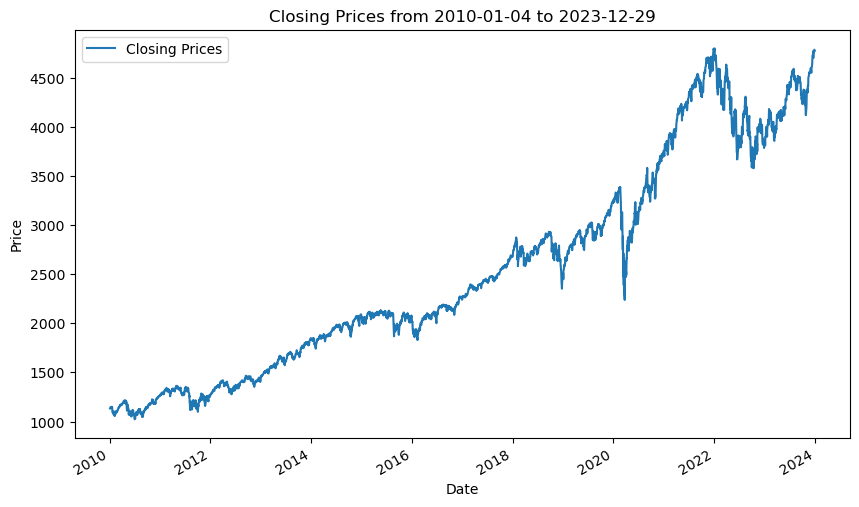

,Price,Adj Close,Close,High,Low,Open,Volume
count,3634,3633,3633,3633,3633,3633,3633
unique,3634,3427,3427,3316,3333,3319,3602
top,Ticker,1.8279999494552612,1.8279999494552612,2.299999952316284,1.8666670322418213,1.8666670322418213,25717500
freq,1,4,4,7,6,6,2


In [21]:
plot_describe()

df.describe()

The `Adjusted Close`, `Close`, and `Open` values have similar statistics, which indicates that the S&P500 companies' prices are adjusted along this period of time.

However, the presence of large standard deviations in price metrics could suggest otherwise. We attribute this issue to:
 - significant increase in price, when comparing 2010 values to 2022.
 - the presence of outliers in the dataset, for example, the price plummeting during COVID

Because GSPC is a broad market indicator, its volumes are quite astronomical in value.

We can expect all of the companies to generally behave like this graph, but values are, of course, different. The graph is a good representation of the overall market behavior, but we must dive into analysis of individual companies to get a better understanding of the data we are going to be working with.

## Preprocessing and Cleanup

SInce we previously formatted our data, we can begin to analyze the `csv` contents.

### Missing Values

The first step is to verify if any of them possess any NaN values. If so, those tickers will be identified so that the faulty `csvs` are not passed into the models.

In [22]:
has_nan = [] 

# Iterate over each file 
for ticker in tickers:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    # Returns True if df has at least one NaN
    if df.isna().any().any(): has_nan.append(ticker)

len(has_nan)


0

### Inconsistent Presence in the S&P500

There are no NaN values in any of our csv files. However, due to the nature of the S&P500, there could be companies that are not consistently part of the dataset, from `2010-01-04` up until `2023-12-29`.

We know that Apple, `AAPL`, has never left the S&P500 since its inclusion in 1982. This means that if we crop the csv file to the specified date range, we can determine the number of rows a perfect training dataset should have:

In [23]:
df = pd.read_csv('./clean_csvs/AAPL.csv')

print("AAPL rows: ", len(df))
df.head()

AAPL rows:  3754


,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


If we use all available days, we would have 3754 rows. However, if we use only the interval mentioned in the project statement, we should have as many rows as the GSPC index, if it in fact did remain consistent for all those years. 

In [24]:
start_date = '2010-01-04'
end_date = '2023-12-29'

# Section into only relevant days
interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

print(f"GSPC rows == ", len(df_gspc))
print(f"AAPL rows == ", len(interval_df))
print("Are they equal? ", len(df_gspc) == len(interval_df))

GSPC rows ==  3522
AAPL rows ==  3522
Are they equal?  True


After confirming that, in fact, the correct row number should be `3522`, the next step consists of collecting all of the tickers with the same number of rows as the interval inside the `tickers_3522` array, and separate them from all of the files with less than 3522 rows inside the `tickers_less_3522` array.

In [25]:
tickers_3522 = []
tickers_less_3522 = []

# Iterate over each file 
for ticker in tickers:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2010-01-04'
    end_date = '2023-12-29'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    if len(interval_df) == 3522: tickers_3522.append(ticker)
    elif len(interval_df) < 3522: tickers_less_3522.append(ticker)

In [26]:
print(len(tickers_3522))
print(len(tickers_less_3522))

430
73


We have some pretty good results. **430 out of the 503** csv files available **show consistency** throghout the **~13 years** we intend to test. 


### Inconsistent Companies

Let's see how many dfifferent row values exist for each of the 73 inconsistent dataframes:

In [27]:
diff_val = {}

# Iterate over each file 
for ticker in tickers_less_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2010-01-04'
    end_date = '2023-12-29'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    row_count = len(interval_df)

    if row_count in diff_val: diff_val[row_count].append(ticker)
    else: diff_val[row_count] = [ticker]
        
print(len(diff_val))

66



In order to showcase all of the different values for the inconsistent companies, while avoiding cluttering, we decided to group them by intervals:

In [28]:
min_diff = min(diff_val)
max_diff = max(diff_val)

print(min_diff, max_diff)

0 3521


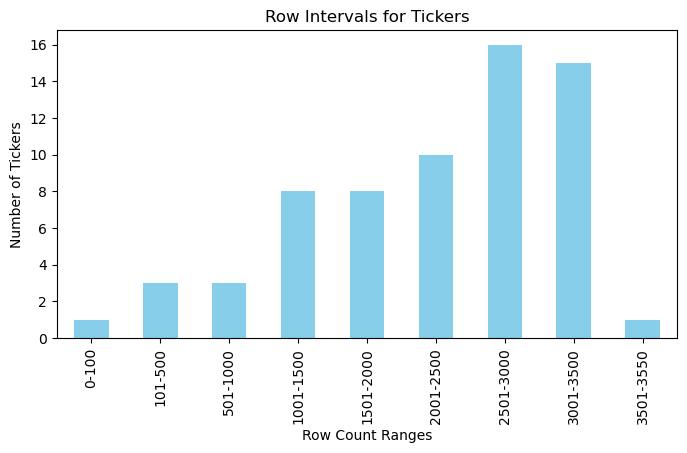

In [29]:
# Group row counts into ranges
ranges = pd.cut(list(diff_val.keys()), bins=[0, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3550], 
                labels=['0-100', '101-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2501-3000', '3001-3500', '3501-3550'])
grouped_data = pd.Series(diff_val.keys()).groupby(ranges, observed=False).size()

plt.figure(figsize=(8,4))
grouped_data.plot(kind='bar', color='skyblue')

plt.title('Row Intervals for Tickers')
plt.xlabel('Row Count Ranges')
plt.ylabel('Number of Tickers')
plt.show()


### Relevant Information for Training

This topic delves into specifics for training models. 

Before training, we attempt to mitigate issues that could negativelly impact predictive performance.

 - Already prevented NaN values from affecting our models, as well as non-trainable data types. 

 - Ensured consistency in the extracted csv's by **sectioning the ~13 year period** <sup>1</sup>.


<sup>1</sup> We can guarantee this, because if all datasets have 3522 entries spanning the same 13 years, they must share the same dates, as identical entry counts indicate no missing or extra data. 
Trading occurs on a market-wide schedule, so if one dataset lacks a date (weekends, holidays), it will be missing in every csv, ensuring consistency.

Furthermore, before working on predicting values, we will analyze the intervals of **values we can expect** to obtain, from the 430 valid tickers, using what we already know from the data.

#### Prices

Since our **budget is limited** to **10000**, with an action cost of **1**, we will identify **intervals of expected prices**. 

In [30]:
diff_prices = {}

# Iterate over each consistent file 
for ticker in tickers_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2024-01-01'
    end_date = '2024-01-31'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    avg_close = interval_df.Close.mean()

    if avg_close in diff_prices: diff_prices[row_count].append(ticker)
    else: diff_prices[avg_close] = [ticker]

Once again, we will take on the approach of sectioning into intervals, to facilitate analysis and avoid cluttering.

In [31]:
min_diff = min(diff_prices)
max_diff = max(diff_prices)

print(min_diff, max_diff)

10.689047631763277 7080.755719866072


This significant difference in value is quite interesting.  

The lower stock values can be attributed to higher volumes, or simply the fact that the company is among the best valued markets in its industry, not in general.

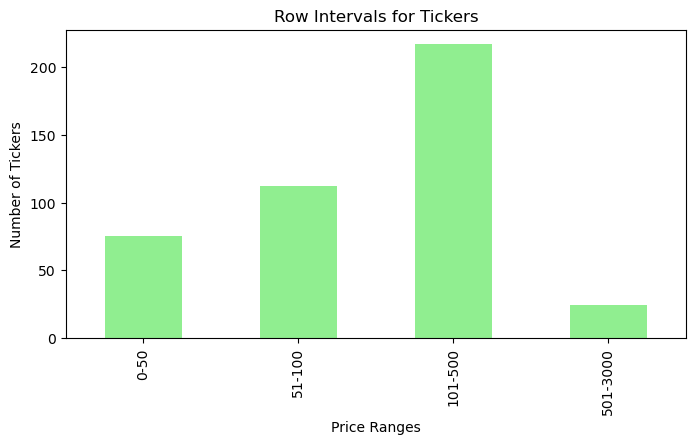

In [32]:
# Group prices into ranges
ranges = pd.cut(list(diff_prices.keys()), bins=[0, 50, 100, 500, 3000], 
                labels = ['0-50', '51-100', '101-500', '501-3000']
)
grouped_data = pd.Series(diff_prices.keys()).groupby(ranges, observed=False).size()

plt.figure(figsize=(8,4))
grouped_data.plot(kind='bar', color='lightgreen')

plt.title('Row Intervals for Tickers')
plt.xlabel('Price Ranges')
plt.ylabel('Number of Tickers')
plt.show()

Through graphical analysis, we find that the vast majority of stocks are priced at under 500\$, which is a relatively low price point, sufficient for experimenting portfolio optimization with some randomized searched methods, such as `MCTS`.

However, we must be careful and take into consideration that the purchase of a 500\$+ stock will severely lower our budget, as those purchases must only be done if the **risk to reward ratio** of potentially missing cheaper stock purchases is justified.\

In order to facilitate that process, we decided to group the tickers of such stocks into separate arrays, which can be used during model implementation:

In [33]:
tickers_500 = []
tickers_500_3000 =[]

# Iterate over each consistent file 
for ticker in tickers_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2024-01-01'
    end_date = '2024-01-31'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    avg_close = interval_df.Close.mean()

    if avg_close <= 500: tickers_500.append(ticker)
    else: tickers_500_3000.append(ticker)


In [34]:
print(f"Price <= 500: {len(tickers_500)} different stocks.")
print(f"Price in ]500, 3000]: {len(tickers_500_3000)} different stocks.")

print("Most expensive tickers: \n")
for i in tickers_500_3000: print(i)

Price <= 500: 404 different stocks.
Price in ]500, 3000]: 26 different stocks.
Most expensive tickers: 

ADBE
AZO
BKNG
BLK
COST
EQIX
FICO
GWW
IDXX
INTU
KLAC
LLY
MPWR
MSCI
MTD
NFLX
NVR
ORLY
REGN
ROP
SNPS
TDG
TMO
TPL
UNH
URI


#### Risk: standard deviation

In order to evaluate the expected risk of investing in January 2024, we decided to adapt our previous code to detect the most volatile and unstable company stocks.

The criteria we used to define risk is **standard deviation**.

In [ ]:
std_dev_prices = {}

for ticker in tickers_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    df = pd.read_csv(file_path)

    start_date = '2024-01-01'
    end_date = '2024-01-31'
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Calculate the standard deviation of the 'Close' column in the sectioned data
    std_deviation = interval_df.Close.std()

    # Store the standard deviation in the dictionary
    std_dev_prices[std_deviation] = ticker

In [38]:
min_diff = min(std_dev_prices)
max_diff = max(std_dev_prices)

print(min_diff, max_diff)

0.2235695023884422 132.74654623611957


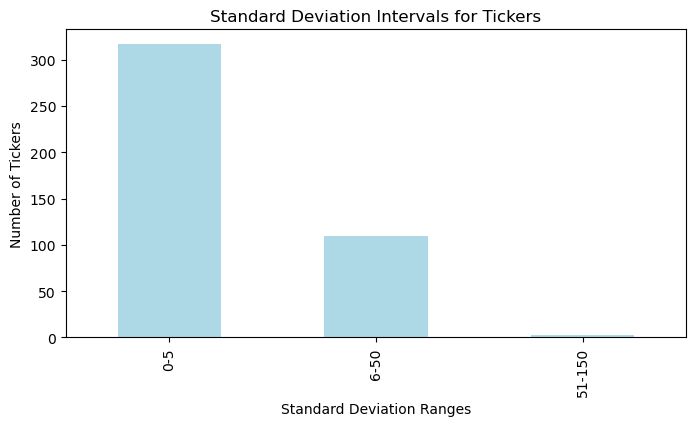

In [40]:
# Assuming std_dev_prices is already populated
# Standard deviation values range from 0.22357 to 132.74655
ranges = pd.cut(
    list(std_dev_prices.keys()),
    bins=[0, 5, 50, 150],  # Define suitable bins for standard deviations
    labels=['0-5', '6-50', '51-150']
)

# Group data by these ranges
grouped_data = pd.Series(std_dev_prices.keys()).groupby(ranges, observed=False).size()

# Plotting
plt.figure(figsize=(8, 4))
grouped_data.plot(kind='bar', color='lightblue')

# Adding titles and labels
plt.title('Standard Deviation Intervals for Tickers')
plt.xlabel('Standard Deviation Ranges')
plt.ylabel('Number of Tickers')
plt.show()


#### Liquidity: volume